In [1]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2023-11-22 20:30:47.122314: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 20:30:47.713827: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-22 20:30:48.379622: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-22 20:30:48.405108: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [5]:
tf.keras.backend.clear_session()

In [6]:
subject = 'Paraíba - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [7]:
data = pd.read_csv('2003_raw_Paraíba_input.csv')
pd.set_option('display.max_columns', None)
data = data.replace(-1.0, np.nan)
data

,data,Paraíba - PIB - Per Capita,Paraíba - PIB - Preços de Mercado,Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Paraíba - População,Paraíba - INCC (%),Paraíba - IPCA - Variação mensal durante o Plano Real (%),Paraíba - IGP-DI,Paraíba - Taxa Selic (%),Paraíba - IDH - Longevidade,Paraíba - IDH - Renda,Paraíba - IDH - Educação,Paraíba - NFSP - Fluxo Mensal (Milhões de reais),Paraíba - Estoque liquido de capital fixo - (R$),Paraíba - Desemprego,Paraíba - Produção de Cimento (t),Paraíba - Valor,Paraíba - Consumo de Cimento (t)
0,2003-01-01,1.802894e+06,9.490183e+05,0.515865,1.250916e+06,3494893.0,1.70,12.53,2.70,0.082293,0.672,0.582,0.331,3.46,6.098524e+06,8.291325,NaN,0.330,38426.0
1,2003-02-01,1.802894e+06,9.490183e+05,0.515865,1.250916e+06,3494893.0,1.51,2.25,2.17,0.088771,0.672,0.582,0.331,3.59,6.172460e+06,8.291325,38546.0,0.330,31672.0
2,2003-03-01,1.802894e+06,9.490183e+05,0.515865,1.250916e+06,3494893.0,1.39,3.86,1.59,0.090733,0.672,0.582,0.331,3.84,6.172460e+06,8.291325,44218.0,0.330,28775.0
3,2003-04-01,1.802894e+06,9.490183e+05,0.515865,1.250916e+06,3494893.0,1.38,5.13,1.66,0.092749,0.672,0.582,0.331,3.95,6.172460e+06,8.291325,108359.0,0.330,28571.0
4,2003-05-01,1.802894e+06,9.490183e+05,0.515865,1.250916e+06,3494893.0,0.90,6.15,0.41,0.092758,0.672,0.582,0.331,4.06,6.172460e+06,8.291325,91326.0,0.330,31613.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2019-08-01,2.825415e+06,4.767442e+06,0.706973,1.683396e+06,3996496.0,0.58,2.42,-0.01,0.024620,0.810,0.690,0.670,0.69,7.827728e+06,12.300000,205025.0,0.420,62219.0
200,2019-09-01,2.825415e+06,4.767442e+06,0.706973,1.683396e+06,3996496.0,0.42,2.54,-0.51,0.022751,0.810,0.690,0.670,0.62,7.827728e+06,12.000000,30305.0,0.365,61329.0
201,2019-10-01,2.825415e+06,4.767442e+06,0.706973,1.683396e+06,3996496.0,0.46,2.49,0.50,0.022035,0.810,0.690,0.670,0.59,7.827728e+06,11.900000,56222.0,0.360,81988.0
202,2019-11-01,2.825415e+06,4.767442e+06,0.706973,1.683396e+06,3996496.0,0.18,2.60,0.55,0.020790,0.810,0.690,0.670,0.57,7.827728e+06,11.700000,15534.0,0.360,79341.0


In [8]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data = target_data/1000
target_data

0      32.450
1      27.763
2      30.131
3      27.103
4      28.053
        ...  
199       NaN
200       NaN
201       NaN
202       NaN
203       NaN
Name: Paraíba - Consumo de Cimento (t), Length: 204, dtype: float64

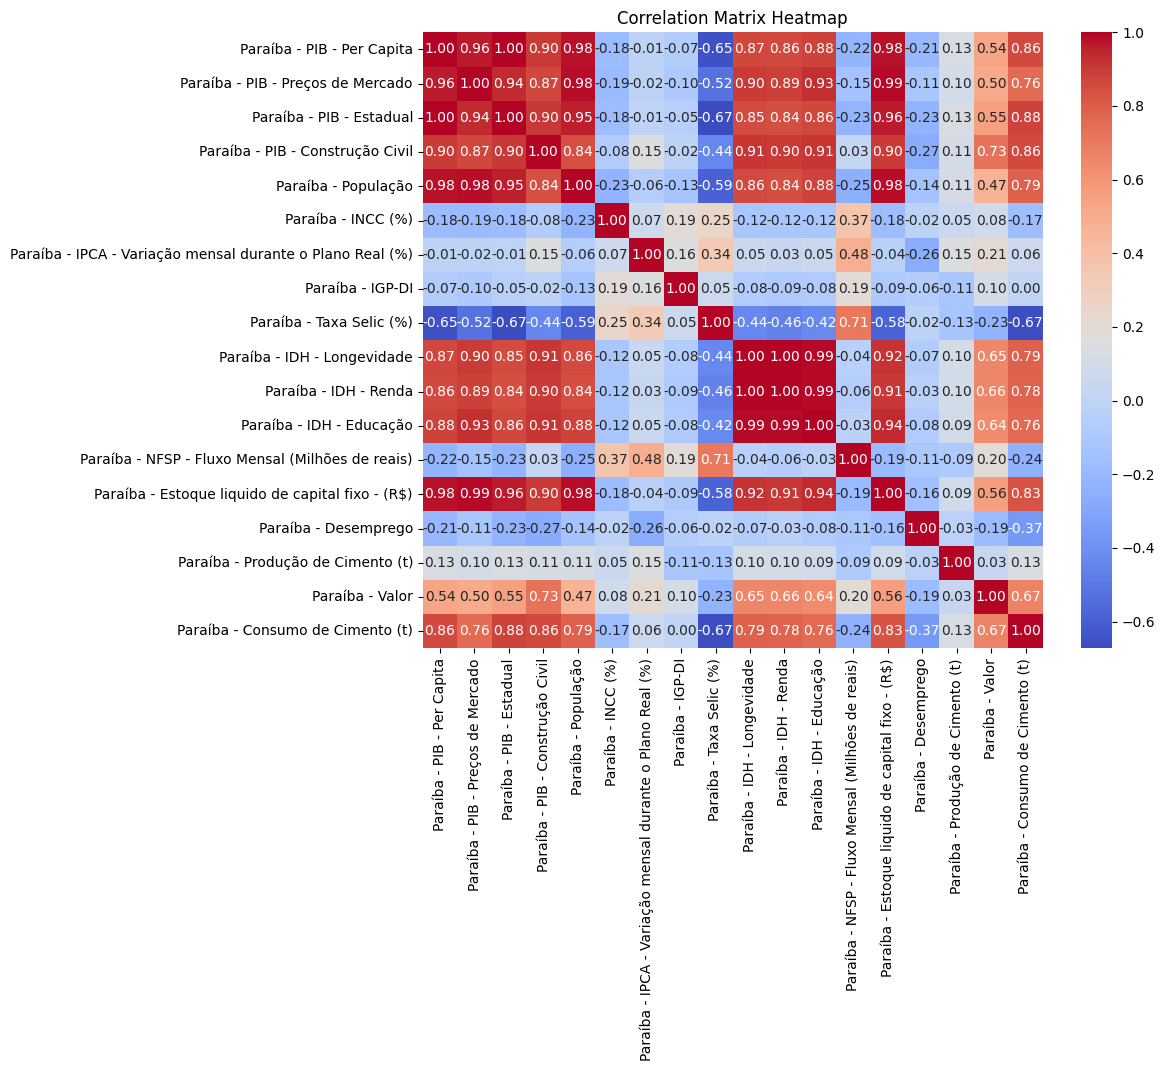

In [9]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [10]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data = input_data.fillna(-1.0)
input_data

,Paraíba - PIB - Per Capita,Paraíba - PIB - Preços de Mercado,Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Paraíba - População,Paraíba - INCC (%),Paraíba - IPCA - Variação mensal durante o Plano Real (%),Paraíba - IGP-DI,Paraíba - Taxa Selic (%),Paraíba - IDH - Longevidade,Paraíba - IDH - Renda,Paraíba - IDH - Educação,Paraíba - NFSP - Fluxo Mensal (Milhões de reais),Paraíba - Estoque liquido de capital fixo - (R$),Paraíba - Desemprego,Paraíba - Produção de Cimento (t),Paraíba - Valor
0,-1.441190,-1.311468,-1.407117,-0.571880,-1.552860,1.998868,4.052332,3.466715,2.303195,-0.93184,-0.931792,-0.919405,3.108599,-1.539424,-0.498485,-1.000000,0.055264
1,-1.441190,-1.311468,-1.407117,-0.571880,-1.552860,1.647487,-0.596188,2.630940,2.745235,-0.93184,-0.931792,-0.919405,3.275709,-1.411460,-0.498485,-0.587893,0.055264
2,-1.441190,-1.311468,-1.407117,-0.571880,-1.552860,1.425561,0.131839,1.716318,2.879123,-0.93184,-0.931792,-0.919405,3.597074,-1.411460,-0.498485,-0.568717,0.055264
3,-1.441190,-1.311468,-1.407117,-0.571880,-1.552860,1.407068,0.706121,1.826703,3.016721,-0.93184,-0.931792,-0.919405,3.738475,-1.411460,-0.498485,-0.351870,0.055264
4,-1.441190,-1.311468,-1.407117,-0.571880,-1.552860,0.519367,1.167355,-0.144465,3.017322,-0.93184,-0.931792,-0.919405,3.879875,-1.411460,-0.498485,-0.409455,0.055264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1.128084,1.758038,0.938763,0.524739,1.593988,-0.590259,-0.966985,-1.264088,-0.729479,1.24472,1.380173,1.464863,-0.374997,1.441346,2.243797,0.028672,0.183157
176,1.128084,1.758038,0.938763,0.524739,1.593988,-0.479297,-0.881068,-0.412544,-0.941281,1.24472,1.380173,1.464863,-0.439270,1.441346,2.243797,-0.651225,0.078517
177,1.128084,1.758038,0.938763,0.524739,1.593988,-1.034110,-0.808718,0.186692,-1.140710,1.24472,1.380173,1.464863,-0.503543,1.441346,2.243797,-0.357394,0.078517
178,1.128084,1.758038,0.938763,0.524739,1.593988,-0.571766,-0.614276,-0.633314,-1.226481,1.24472,1.380173,1.464863,-0.503543,1.441346,2.319789,-0.660255,0.491262


In [11]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Paraíba - PIB - Per Capita,Paraíba - PIB - Preços de Mercado,Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Paraíba - População,Paraíba - INCC (%),Paraíba - IPCA - Variação mensal durante o Plano Real (%),Paraíba - IGP-DI,Paraíba - Taxa Selic (%),Paraíba - IDH - Longevidade,Paraíba - IDH - Renda,Paraíba - IDH - Educação,Paraíba - NFSP - Fluxo Mensal (Milhões de reais),Paraíba - Estoque liquido de capital fixo - (R$),Paraíba - Desemprego,Paraíba - Produção de Cimento (t),Paraíba - Valor
0,-1.44119,-1.311468,-1.407117,-0.571880,-1.552860,1.998868,4.052332,3.466715,2.303195,-0.93184,-0.931792,-0.919405,3.108599,-1.539424,-0.498485,-1.000000,0.055264
1,-1.44119,-1.311468,-1.407117,-0.571880,-1.552860,1.647487,-0.596188,2.630940,2.745235,-0.93184,-0.931792,-0.919405,3.275709,-1.411460,-0.498485,-0.587893,0.055264
2,-1.44119,-1.311468,-1.407117,-0.571880,-1.552860,1.425561,0.131839,1.716318,2.879123,-0.93184,-0.931792,-0.919405,3.597074,-1.411460,-0.498485,-0.568717,0.055264
3,-1.44119,-1.311468,-1.407117,-0.571880,-1.552860,1.407068,0.706121,1.826703,3.016721,-0.93184,-0.931792,-0.919405,3.738475,-1.411460,-0.498485,-0.351870,0.055264
4,-1.44119,-1.311468,-1.407117,-0.571880,-1.552860,0.519367,1.167355,-0.144465,3.017322,-0.93184,-0.931792,-0.919405,3.879875,-1.411460,-0.498485,-0.409455,0.055264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.31015,1.555669,1.227283,1.221425,1.424253,-0.238878,0.629248,-1.406012,0.272188,1.24472,1.012360,1.319923,0.794771,1.416222,-0.035944,-1.000000,-0.700466
164,1.31015,1.555669,1.227283,1.221425,1.424253,-0.608753,0.837256,-0.112926,0.272188,1.24472,1.012360,1.319923,0.730498,1.416222,0.040047,-1.000000,-0.438867
165,1.31015,1.555669,1.227283,1.221425,1.424253,-0.534778,0.877953,-0.743700,0.272188,1.24472,1.012360,1.319923,0.743353,1.416222,0.116039,-1.000000,-0.380734
166,1.31015,1.555669,1.227283,1.221425,1.424253,-0.756703,1.000045,-0.586006,0.248413,1.24472,1.012360,1.319923,0.614807,1.416222,0.116039,-1.000000,-0.467933


In [12]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      32.450
1      27.763
2      30.131
3      27.103
4      28.053
        ...  
163    64.217
164    57.591
165    64.307
166    61.971
167    57.480
Name: Paraíba - Consumo de Cimento (t), Length: 168, dtype: float64

In [13]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [14]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 17)

In [15]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Paraíba - PIB - Per Capita,Paraíba - PIB - Preços de Mercado,Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Paraíba - População,Paraíba - INCC (%),Paraíba - IPCA - Variação mensal durante o Plano Real (%),Paraíba - IGP-DI,Paraíba - Taxa Selic (%),Paraíba - IDH - Longevidade,Paraíba - IDH - Renda,Paraíba - IDH - Educação,Paraíba - NFSP - Fluxo Mensal (Milhões de reais),Paraíba - Estoque liquido de capital fixo - (R$),Paraíba - Desemprego,Paraíba - Produção de Cimento (t),Paraíba - Valor
132,0.931044,0.880461,0.884293,1.121125,1.063856,-0.960135,1.058830,0.297077,-0.755853,1.074677,1.012360,0.957572,-0.285015,0.834026,-1.251806,1.862195,1.537657
133,0.931044,0.880461,0.884293,1.121125,1.063856,0.482379,-1.364912,-0.160234,-0.688658,1.074677,1.012360,0.957572,-0.349288,1.129318,-0.871849,-1.000000,1.433017
134,0.931044,0.880461,0.884293,1.121125,1.063856,-0.534778,-1.052901,0.549386,-0.626634,1.074677,1.012360,0.957572,-0.374997,1.129318,-0.643875,-1.000000,2.212000
135,0.931044,0.880461,0.884293,1.121125,1.063856,-0.627247,-0.627842,1.542855,-0.571481,1.074677,1.012360,0.957572,-0.259306,1.129318,-0.795858,-1.000000,2.432906
136,0.931044,0.880461,0.884293,1.121125,1.063856,0.482379,-0.320352,-0.081387,-0.516512,1.074677,1.012360,0.957572,-0.053632,1.129318,-0.947841,-1.000000,2.363146
137,0.931044,0.880461,0.884293,1.121125,1.063856,2.646150,-0.107822,-1.500628,-0.510405,1.074677,1.012360,0.957572,0.023495,1.129318,-1.099823,-1.000000,1.723683
138,0.931044,0.880461,0.884293,1.121125,1.063856,0.075516,0.082098,-1.784477,-0.510405,1.074677,1.012360,0.957572,-0.002214,1.129318,-1.175815,-1.000000,1.456271
139,0.931044,0.880461,0.884293,1.121125,1.063856,0.241960,0.086620,-1.658322,-0.510405,1.074677,1.012360,0.957572,-0.143614,1.129318,-1.327797,-1.000000,1.450457
140,0.931044,0.880461,0.884293,1.121125,1.063856,-0.997122,0.204189,-0.696392,-0.510054,1.074677,1.012360,0.957572,-0.182178,1.129318,-1.479780,-1.000000,1.456271
141,0.931044,0.880461,0.884293,1.121125,1.063856,-0.867666,0.470982,-0.759469,-0.510405,1.074677,1.012360,0.957572,-0.105051,1.129318,-1.631763,-1.000000,1.648110


In [16]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 17)

In [22]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)

    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(144, activation='tanh', 
                             return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.l1(0.01),
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(144, activation='tanh', 
                             return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.l1(0.01)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(36, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
#                         validation_data=(train_val,
#                                          target_val),
                        validation_split=0.15,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [23]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [24]:
def predictor(model, test_input, test_target, start_target):
    
    predictions = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        if (prediction[0][0] < 0.0):
            return None, None
        predictions.append(prediction[0][0])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    return df_results, predictions

In [25]:
def statistical_validator(train_input, train_target, test_input, test_target, start_target):
    
    pd.set_option('display.max_columns', None)
    predictions_list = []
    error_percent = []
    
    i = 0
    while i < 10:
        winner_seed = get_a_good_seed(train_input, train_target, test_input, test_target)
        trained_model, history = lstm_model(train_input, 
                                            train_target, 
                                            want_verbose=0, 
                                            seed=winner_seed)
        df_results, predictions = predictor(trained_model, 
                                            test_input, 
                                            test_target, 
                                            start_index)
        if predictions is not None:
            display(df_results.T)
            predictions_list.append(predictions)
            i += 1
        
    predictions_means = np.mean(predictions_list, axis=0)
    results_data = []
   
    for j in range(12):
        target = test_target[start_target + j]
        error = np.abs(predictions_means[j] - target)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                            predictions_means[j], 
                            target, 
                            error])
    display("FINAL___________________________________________________________________")
    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    display(df_results.T)
        
    mae_mean = np.mean(predictions_means)
    mape_mean = np.mean(error_percent) 

    return mae_mean, mape_mean

In [26]:
mae, mape = statistical_validator(reshaped_train, 
                                  reshaped_target, 
                                  reshaped_test, 
                                  reshaped_test_target, 
                                  start_index)

[3511747893, 3779693634, 643057932, 2737039686, 1655928446, 1807995031, 3273031676, 1689730183, 127414686, 904650908]


Step: 0 ___________________________________________
val_loss: 50.91625213623047
winner_seed: 3511747893


Step: 1 ___________________________________________
val_loss: 101.94367218017578


Step: 2 ___________________________________________
val_loss: 41.56843566894531
winner_seed: 643057932


Step: 3 ___________________________________________
val_loss: 38.74882125854492
winner_seed: 2737039686


Step: 4 ___________________________________________
val_loss: 32.089210510253906
winner_seed: 1655928446


Step: 5 ___________________________________________
val_loss: 42.17963409423828


Step: 6 ___________________________________________
val_loss: 83.5042724609375


Step: 7 ___________________________________________
val_loss: 23.906545639038086
winner_seed: 1689730183


Step: 8 ___________________________________________
val_loss: 111.25404357910156


Step: 9 ____________

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,58.896442,57.165577,57.213188,57.631165,58.385307,58.424702,57.659557,63.190258,67.062401,68.283134,65.098473,61.759716
Target,68.053,55.231,53.723,57.457,62.755,48.148,62.19,62.219,61.329,81.988,79.341,76.646
Error,9.156559,1.934578,3.490189,0.174164,4.369694,10.276703,4.530441,0.971256,5.733402,13.704865,14.242531,14.886288


[3157779471, 2096292062, 2236094194, 1808450364, 1548369935, 3875644591, 2202283782, 3136471058, 813406159, 219656549]


Step: 0 ___________________________________________
val_loss: 109.13824462890625
winner_seed: 3157779471


Step: 1 ___________________________________________
val_loss: 40.38898468017578
winner_seed: 2096292062


Step: 2 ___________________________________________
val_loss: 40.54511642456055


Step: 3 ___________________________________________
val_loss: 24.50950050354004
winner_seed: 1808450364


Step: 4 ___________________________________________
val_loss: 55.38837814331055


Step: 5 ___________________________________________
val_loss: 43.816261291503906


Step: 6 ___________________________________________
val_loss: 15.799057006835938
winner_seed: 2202283782


Step: 7 ___________________________________________
val_loss: 46.72612762451172


Step: 8 ___________________________________________
val_loss: 98.86427307128906


Step: 9 __________________________________

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,58.865856,57.963806,58.024048,58.489925,59.638622,61.505245,62.057987,63.791531,64.135391,63.63142,62.982319,61.955765
Target,68.053,55.231,53.723,57.457,62.755,48.148,62.19,62.219,61.329,81.988,79.341,76.646
Error,9.187145,2.732807,4.301048,1.032925,3.116379,13.357246,0.132011,1.572529,2.806393,18.356579,16.358685,14.690239


[1464860449, 2130353798, 3614950774, 2159376407, 3419110460, 211146904, 625570697, 3592199166, 2808217965, 2448956000]


Step: 0 ___________________________________________
val_loss: 29.549915313720703
winner_seed: 1464860449


Step: 1 ___________________________________________
val_loss: 26.732019424438477
winner_seed: 2130353798


Step: 2 ___________________________________________
val_loss: 48.700538635253906


Step: 3 ___________________________________________
val_loss: 54.540199279785156


Step: 4 ___________________________________________
val_loss: 78.4704818725586


Step: 5 ___________________________________________
val_loss: 39.29413986206055


Step: 6 ___________________________________________
val_loss: 123.00357818603516


Step: 7 ___________________________________________
val_loss: 104.09880065917969


Step: 8 ___________________________________________
val_loss: 28.175457000732422


Step: 9 ___________________________________________
val_loss: 80.68840026855469
1/1 [==

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,59.004288,59.365494,63.603943,64.530899,60.845871,59.437859,62.130981,64.763931,63.449085,61.394424,58.333199,58.700157
Target,68.053,55.231,53.723,57.457,62.755,48.148,62.19,62.219,61.329,81.988,79.341,76.646
Error,9.048714,4.134495,9.880943,7.073898,1.90913,11.28986,0.059017,2.54493,2.120087,20.593575,21.007805,17.945847


[4097624320, 4225556575, 1568750812, 874731518, 2208453201, 1440431178, 1474415979, 1296395969, 3748423094, 3076985094]


Step: 0 ___________________________________________
val_loss: 34.6956901550293
winner_seed: 4097624320


Step: 1 ___________________________________________
val_loss: 44.57862091064453


Step: 2 ___________________________________________
val_loss: 47.894447326660156


Step: 3 ___________________________________________
val_loss: 254.4796905517578


Step: 4 ___________________________________________
val_loss: 64.38141632080078


Step: 5 ___________________________________________
val_loss: 43.2514533996582


Step: 6 ___________________________________________
val_loss: 45.959388732910156


Step: 7 ___________________________________________
val_loss: 48973460.0


Step: 8 ___________________________________________
val_loss: 24.73792266845703
winner_seed: 3748423094


Step: 9 ___________________________________________
val_loss: 45.05673599243164
1/1 [==============

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,59.368263,58.971397,59.30014,59.301407,59.348511,59.643227,60.249588,60.673729,62.021729,61.873856,61.822609,61.688179
Target,68.053,55.231,53.723,57.457,62.755,48.148,62.19,62.219,61.329,81.988,79.341,76.646
Error,8.684738,3.740398,5.577141,1.844406,3.40649,11.495228,1.940411,1.545273,0.69273,20.114143,17.518394,14.957825


[3568165621, 2567890860, 3466578481, 3919784061, 3337352157, 2406709333, 833412905, 920068849, 2034368740, 175645159]


Step: 0 ___________________________________________
val_loss: 31.64047622680664
winner_seed: 3568165621


Step: 1 ___________________________________________
val_loss: 57.37487030029297


Step: 2 ___________________________________________
val_loss: 39.94976806640625


Step: 3 ___________________________________________
val_loss: 64.65478515625


Step: 4 ___________________________________________
val_loss: 59.212852478027344


Step: 5 ___________________________________________
val_loss: 50.189537048339844


Step: 6 ___________________________________________
val_loss: 51.4407958984375


Step: 7 ___________________________________________
val_loss: 23.31668472290039
winner_seed: 920068849


Step: 8 ___________________________________________
val_loss: 42.3986701965332


Step: 9 ___________________________________________
val_loss: 40.70196533203125
1/1 [=============

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,64.262428,60.297127,60.342964,59.814693,64.099953,65.229652,61.747738,63.15303,68.038307,65.974258,65.361046,65.791222
Target,68.053,55.231,53.723,57.457,62.755,48.148,62.19,62.219,61.329,81.988,79.341,76.646
Error,3.790573,5.066128,6.619965,2.357693,1.344952,17.081654,0.442261,0.934029,6.709309,16.013741,13.979958,10.854782


[1881464491, 2925506119, 4092042605, 975779755, 3280547874, 649199874, 2228401905, 624950396, 1858604727, 702782282]


Step: 0 ___________________________________________
val_loss: 28.337879180908203
winner_seed: 1881464491


Step: 1 ___________________________________________
val_loss: 70.75300598144531


Step: 2 ___________________________________________
val_loss: 42.176414489746094


Step: 3 ___________________________________________
val_loss: 58.57568359375


Step: 4 ___________________________________________
val_loss: 35.78073501586914


Step: 5 ___________________________________________
val_loss: 49.2310791015625


Step: 6 ___________________________________________
val_loss: 415.80035400390625


Step: 7 ___________________________________________
val_loss: 24.329668045043945
winner_seed: 624950396


Step: 8 ___________________________________________
val_loss: 43.709007263183594


Step: 9 ___________________________________________
val_loss: 31.852100372314453
1/1 [=========

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,59.719456,60.067184,60.718204,60.07098,58.257771,59.474415,63.188198,63.655689,63.760685,62.421566,58.01141,59.072662
Target,68.053,55.231,53.723,57.457,62.755,48.148,62.19,62.219,61.329,81.988,79.341,76.646
Error,8.333546,4.836185,6.995205,2.613979,4.497231,11.326416,0.998199,1.436687,2.431686,19.566433,21.329594,17.573341


[3871281705, 2115479889, 3960861343, 1312305263, 3358831921, 835809665, 4123048379, 254785175, 1627559413, 1759997169]


Step: 0 ___________________________________________
val_loss: 42.261756896972656
winner_seed: 3871281705


Step: 1 ___________________________________________
val_loss: 68.23584747314453


Step: 2 ___________________________________________
val_loss: 52.92664337158203


Step: 3 ___________________________________________
val_loss: 50.6732292175293


Step: 4 ___________________________________________
val_loss: 33.4622802734375
winner_seed: 3358831921


Step: 5 ___________________________________________
val_loss: 161.3186798095703


Step: 6 ___________________________________________
val_loss: 34.82568359375


Step: 7 ___________________________________________
val_loss: 62.31043243408203


Step: 8 ___________________________________________
val_loss: 182.35934448242188


Step: 9 ___________________________________________
val_loss: 157.69808959960938
1/1 [==========

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,63.297085,63.285496,63.291393,63.286396,63.288986,63.297012,63.29324,63.254932,63.285255,63.296719,63.29541,63.293888
Target,68.053,55.231,53.723,57.457,62.755,48.148,62.19,62.219,61.329,81.988,79.341,76.646
Error,4.755917,8.054497,9.568394,5.829395,0.533985,15.149014,1.103241,1.035931,1.956257,18.69128,16.045593,13.352116


[162999338, 2653460803, 166278724, 4177281851, 1223262504, 747612957, 3523794409, 1313420811, 237243316, 2082871022]


Step: 0 ___________________________________________
val_loss: 71.02304077148438
winner_seed: 162999338


Step: 1 ___________________________________________
val_loss: 45.54484939575195
winner_seed: 2653460803


Step: 2 ___________________________________________
val_loss: 59.147544860839844


Step: 3 ___________________________________________
val_loss: 596.1998901367188


Step: 4 ___________________________________________
val_loss: 71.31153869628906


Step: 5 ___________________________________________
val_loss: 94.5111083984375


Step: 6 ___________________________________________
val_loss: 154.6466064453125


Step: 7 ___________________________________________
val_loss: 56.333595275878906


Step: 8 ___________________________________________
val_loss: 73.93186950683594


Step: 9 ___________________________________________
val_loss: 34.50370407104492
winner_seed: 20

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,61.102852,59.066978,59.316322,59.902878,58.878387,58.518822,60.25145,62.780251,65.305153,65.540001,65.214043,61.955093
Target,68.053,55.231,53.723,57.457,62.755,48.148,62.19,62.219,61.329,81.988,79.341,76.646
Error,6.95015,3.835979,5.593323,2.445877,3.876614,10.370823,1.938549,0.561249,3.976154,16.447998,14.126961,14.69091


[398679778, 1530164955, 384940056, 4004289132, 1349375816, 4180188822, 2534539659, 646755131, 4202237518, 3577478426]


Step: 0 ___________________________________________
val_loss: 39.60417556762695
winner_seed: 398679778


Step: 1 ___________________________________________
val_loss: 32.30364990234375
winner_seed: 1530164955


Step: 2 ___________________________________________
val_loss: 52.8437385559082


Step: 3 ___________________________________________
val_loss: 42.07032012939453


Step: 4 ___________________________________________
val_loss: 37.168785095214844


Step: 5 ___________________________________________
val_loss: 30.115856170654297
winner_seed: 4180188822


Step: 6 ___________________________________________
val_loss: 178.94252014160156


Step: 7 ___________________________________________
val_loss: 34.073455810546875


Step: 8 ___________________________________________
val_loss: 54.5899658203125


Step: 9 ___________________________________________
val_loss: 57.7252

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,61.694084,61.64402,61.786316,62.086613,62.186699,61.899334,62.217358,66.089035,69.111427,68.488304,65.743164,64.054886
Target,68.053,55.231,53.723,57.457,62.755,48.148,62.19,62.219,61.329,81.988,79.341,76.646
Error,6.358917,6.413021,8.063316,4.629612,0.568302,13.751335,0.027359,3.870033,7.782429,13.499695,13.597839,12.591118


[1183235056, 2735377632, 3127699892, 4249340805, 2547739934, 699435627, 3815428506, 609820908, 1045477869, 2891716667]


Step: 0 ___________________________________________
val_loss: 33.542137145996094
winner_seed: 1183235056


Step: 1 ___________________________________________
val_loss: 71.68234252929688


Step: 2 ___________________________________________
val_loss: 25.19146728515625
winner_seed: 3127699892


Step: 3 ___________________________________________
val_loss: 102.52640533447266


Step: 4 ___________________________________________
val_loss: 46.294918060302734


Step: 5 ___________________________________________
val_loss: 43.22950744628906


Step: 6 ___________________________________________
val_loss: 19.532676696777344
winner_seed: 3815428506


Step: 7 ___________________________________________
val_loss: 43.343772888183594


Step: 8 ___________________________________________
val_loss: 30.92091941833496


Step: 9 ___________________________________________
val_loss: 50

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,58.670837,58.863518,63.323441,59.016953,59.273293,59.545204,59.254028,62.8405,64.645599,64.82177,65.533577,65.134979
Target,68.053,55.231,53.723,57.457,62.755,48.148,62.19,62.219,61.329,81.988,79.341,76.646
Error,9.382164,3.632519,9.600441,1.559952,3.481709,11.397205,2.93597,0.621498,3.316601,17.166229,13.807426,11.511024


'FINAL___________________________________________________________________'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11
Prediction,60.488159,59.66906,60.691994,60.413197,60.420341,60.697548,61.205009,63.419292,65.081505,64.572548,63.139526,62.340649
Target,68.053,55.231,53.723,57.457,62.755,48.148,62.19,62.219,61.329,81.988,79.341,76.646
Error,7.564841,4.43806,6.968994,2.956197,2.334659,12.549548,0.984991,1.200292,3.752505,17.415452,16.201474,14.305351


In [27]:
display(mae)
display(mape)

61.844906

0.11417569087690917